# GEO1003 ~ Wi-Fi Fingerprinting

December 2023

Work by Tom Barbian (5100704), Der Derian Auliyaa Bainus (5941342), Corné Snoeij (5174473), Javier Martínez (6055613)

### Importing libraries

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

### Loading the data

##### Wi-Fi fingerprinting data

In [4]:
# load the files within folder /data/fingerprints into a list
wifi_path = os.getcwd() + '/data/fingerprints'
wifi_files = os.listdir(wifi_path)

# load the files into a list of dataframes
df_dict = {}

for file in wifi_files:
    try:
        df_dict[file] = pd.read_csv(wifi_path + '/' + file, sep='\t', header=0)
        df_dict[file].rename(columns={df_dict[file].columns[0]: "timestamp"}, inplace=True)
        df_dict[file].insert(0, 'room', file)

    except Exception as e:
        print(f"error reading file {file}: {e}")
        continue

error reading file .DS_Store: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


##### GNSS nmea data

In [5]:
# This function was coded by Lars, but modified to save to dataframe

def get_sat_values(filename):
    PDOP, HDOP, VDOP, latitude, longitude, num_used_satellites, altitude = [], [], [], [], [], [], []

    with open(filename, 'r') as file:
        lines = file.readlines()
        # divide messages
        messages = [lines[i:i + 7] for i in range(0, len(lines), 7)]

        for message in messages:
            PDOP.append(float(message[0].split(',')[15]))
            HDOP.append(float(message[0].split(',')[16]))
            VDOP.append(float(message[0].split(',')[17][:3]))
            latitude.append(float(message[6].split(',')[2:3][0]))
            longitude.append(float(message[6].split(',')[4:5][0]))
            num_used_satellites.append(int(message[6].split(',')[6]))
            altitude.append(float(message[6].split(',')[9:10][0]))

    # Create a DataFrame
    df = pd.DataFrame({
        'PDOP': PDOP,
        'HDOP': HDOP,
        'VDOP': VDOP,
        'latitude': latitude,
        'longitude': longitude,
        'num_used_satellites': num_used_satellites,
        'altitude': altitude
    })

    return df

In [6]:
# load the files within folder /data/fingerprints into a list
nmea_path = os.getcwd() + '/data/nmea'
nmea_files = os.listdir(nmea_path)

# load the nmea files into a list of dataframes
nmea_dict = {}

for file in nmea_files:
    nmea_dict[file] = get_sat_values(nmea_path + '/' + file)
    # divide latitude and longitude by 100 to get the correct value
    nmea_dict[file]['latitude'] = nmea_dict[file]['latitude'] / 100
    nmea_dict[file]['longitude'] = nmea_dict[file]['longitude'] / 100
    nmea_dict[file]['ID'] = file

##### Snapshot data

In [7]:
# load the files within folder /data/snapshots
snapshot_path = os.getcwd() + '/data/snapshots'
snapshot_files = os.listdir(snapshot_path)

# load the files into a list of dataframes
snapshot_dict = {}

for file in snapshot_files:
    try:
        snapshot_dict[file] = pd.read_csv(snapshot_path + '/' + file, sep='\t', header=0)
        snapshot_dict[file].rename(columns={snapshot_dict[file].columns[0]: "timestamp"}, inplace=True)
        snapshot_dict[file].insert(0, 'room', file)
    except Exception as e:
        print(f"error reading file {file}: {e}")
        continue

### A. Radio Mapping Phase

BK-City floor plan can be found [here.](https://www.tudelft.nl/bk/over-faculteit/het-gebouw/plattegrond/)

##### A1. Scatterplots of GNSS accuracy
Illuminate the estimated GNSS accuracy of this indoor location through a visual representation in
a scatterplot. Don't forget to include key metrics like standard deviation, HDOP, and VDOP.

In [8]:
def print_statistics(dict):
    # Create table with mean, std of lat, lon, HDOP, VDOP, PDOP for each measurement
    statistics_dfs = []
    for key, value in dict.items():
        # Calculate the mean and std for each dataframe
        statistics_df = value.groupby('ID').agg({
            'latitude': ['mean', 'std'],
            'longitude': ['mean', 'std'],
            'HDOP': ['mean', 'std'],
            'VDOP': ['mean', 'std'],
            'PDOP': ['mean', 'std']
        }).reset_index()
        # Add the measurement name to the dataframe at first column
        statistics_df.insert(0, 'measurement', key)
        statistics_dfs.append(statistics_df)

    result_df = pd.concat(statistics_dfs, axis=0)
    result_df = result_df.drop(columns=['ID'], level=0)

    return result_df

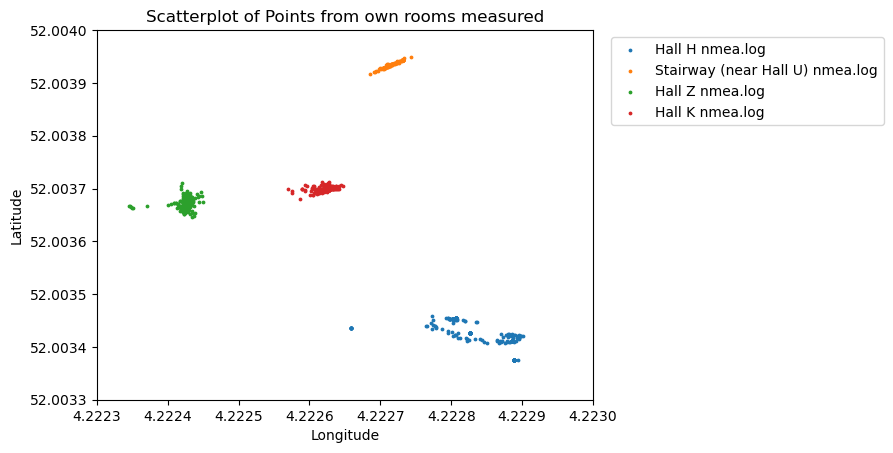

In [9]:
# plot latitude and longitude for each of the nmea files in one scatterplot with different colors
for key, df in nmea_dict.items():
    plt.scatter(df['longitude'], df['latitude'], label=key, s=3)

plt.xlim(4.2223, 4.223)
plt.ylim(52.0033, 52.004)

# ctx.add_basemap(plt.gca(), crs='epsg:4326', source=ctx.providers.OpenStreetMap.Mapnik, zoom=19)

plt.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatterplot of Points from own rooms measured')
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
# plt.savefig('scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
print("Statistics table")
print_statistics(nmea_dict)

Statistics table


measurement   latitude           longitude            \
                                         mean       std      mean       std   
0                  Hall H nmea.log  52.003425  0.000023  4.222848  0.000044   
0  Stairway (near Hall U) nmea.log  52.003934  0.000007  4.222715  0.000012   
0                  Hall Z nmea.log  52.003673  0.000011  4.222423  0.000015   
0                  Hall K nmea.log  52.003700  0.000004  4.222622  0.000013   

       HDOP                VDOP                PDOP            
       mean       std      mean       std      mean       std  
0  1.667746  1.327621  0.475777  0.465847  1.771632  1.368019  
0  7.193913  0.744723  1.138261  0.664723  7.292174  0.815007  
0  7.155618  0.860690  1.206180  0.783600  7.280337  0.935735  
0  7.020468  0.267652  0.815205  0.505386  7.069006  0.332952

##### A2. Comparison of Wi-Fi fingerprinting from two proximate (geographically) locations
Gauge the degree of similarity between these fingerprints. **Alternatively**, on a broader scale, assess
the 'distance' between the 32 identifiable places in RSS-space. In essence, explore how
distinguishable these places are from each other.

We would like to assess the degree of similarity between two rooms: ROOM M and ROOM H, those rooms are next to each other in the BK building. First we show the averages of each of their two fingerprints.

In [11]:
# Extract Wi-Fi fingerprints for the two rooms
hall_m_df = df_dict['M.txt']
hall_h_df = df_dict['H.txt']

# Select relevant columns for comparison
selected_columns = ['Signal Strength', 'Quality', 'Station Count']

# Handling NaN values by filling them with the mean of the column
hall_m_df = hall_m_df[selected_columns].fillna(hall_m_df[selected_columns].mean())
hall_h_df = hall_h_df[selected_columns].fillna(hall_h_df[selected_columns].mean())

# Extract features for halls M and H
hall_m_features = hall_m_df[selected_columns].to_numpy()
hall_h_features = hall_h_df[selected_columns].to_numpy()

# Calculate averages and standard deviations
hall_m_avg = hall_m_df.mean()
hall_h_avg = hall_h_df.mean()
hall_m_std = hall_m_df.std()
hall_h_std = hall_h_df.std()

# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'Hall M Avg': hall_m_avg,
    'Hall H Avg': hall_h_avg,
    'Hall M Std': hall_m_std,
    'Hall H Std': hall_h_std
})

# Display the dataframe
comparison_df

,Hall M Avg,Hall H Avg,Hall M Std,Hall H Std
Signal Strength,-75.262687,-74.924231,9.871511,10.497912
Quality,50.408012,50.614977,22.616157,23.772682
Station Count,0.544799,1.650607,1.552446,3.955809



We can also visualize a plot of the average strength of the signal for both rooms.

First twe get for all dataframes the 10 strongest signals.

In [12]:
from scipy.spatial.distance import pdist, squareform

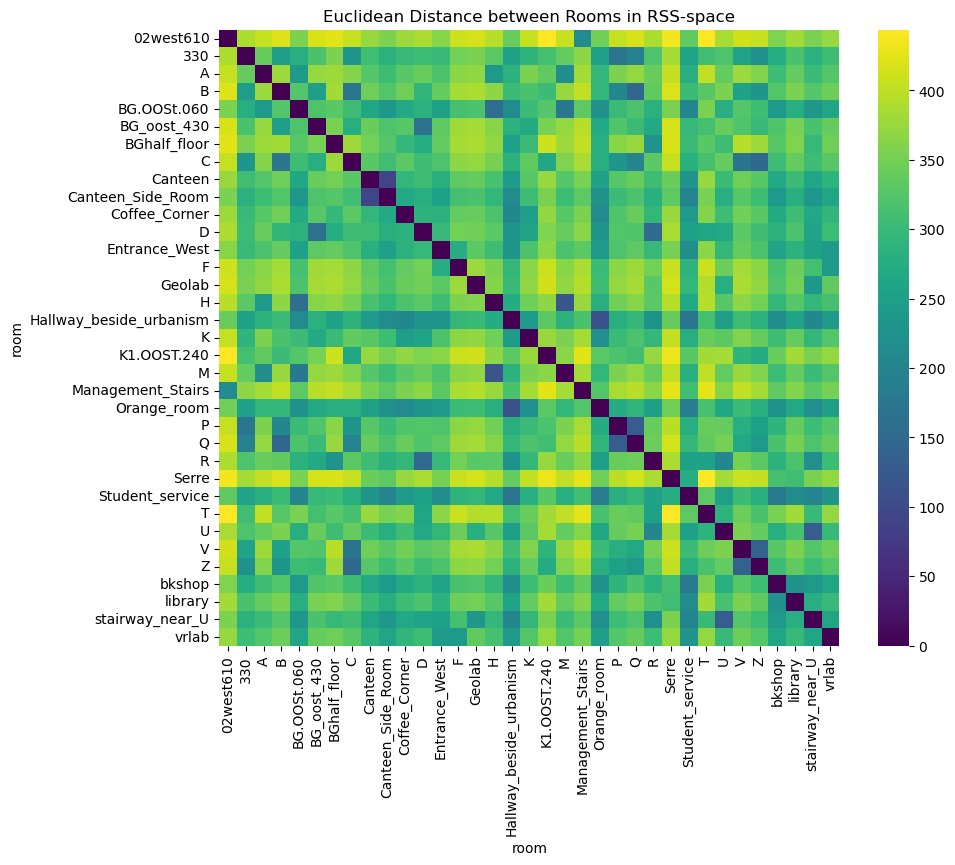

In [13]:
# Assuming df_dict is a dictionary where keys are room numbers and values are DataFrames
all_data = pd.concat([df.assign(room=room) for room, df in df_dict.items()])
# remove .txt in room column of all_data
all_data['room'] = all_data['room'].str.replace('.txt', '')

# Pivot the DataFrame
pivot_df = all_data.pivot_table(index='room', columns='MAC Address', values='Signal Strength', fill_value=-100) # -dBm as indication of weak signal

# Calculate Euclidean distances
distances = pdist(pivot_df.values, metric='euclidean')
distance_matrix = squareform(distances)

# Convert to a DataFrame for easier handling
distance_df = pd.DataFrame(distance_matrix, index=pivot_df.index, columns=pivot_df.index)

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', annot=False)
plt.title('Euclidean Distance between Rooms in RSS-space')
plt.savefig('Euclidean Distance between Rooms in RSS-space.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Get the 10 strongest signals for each room
df_dict['M.txt'].groupby(["MAC Address"]).agg({'room': 'first',
                                     'Signal Strength': 'mean'}).sort_values(by='Signal Strength', ascending=True)[:5].reset_index()

,MAC Address,room,Signal Strength
0,00:1E:42:4C:89:FC,M.txt,-90.937500
1,1C:28:AF:62:B8:B2,M.txt,-89.620690
2,D0:4D:C6:F2:F4:B1,M.txt,-89.552632
3,1C:28:AF:62:B8:B0,M.txt,-89.382353
4,D0:4D:C6:F2:F4:B2,M.txt,-89.011905


##### B. Localization Phase

Extend your Wi-Fi fingerprint exploration by measuring at four locations distinct from your radio
mapping data—specifically, locations measured by other groups (request their measurements).
Employ a 30-second snapshot, akin to phase A (15 minutes at least).

Now, leverage a pattern recognition matching algorithm, such as minimizing the sum of squares, to
identify the best fit among the 32 fingerprints corresponding to recognizable places.
- B1. Were you able to successfully pinpoint these four locations?
- B2. How confident are you in your findings?

In [15]:
# We use data from df_dict and snapshot_dict
df_dict['M.txt'].head()

,room,timestamp,MAC Address,Vendor,SSID,Access Point Name,Connected AP,Signal Strength,Quality,Station Count,Frequency,Position,Info,Adapter
0,M.txt,2023/12/8 17:31:57,1C:28:AF:66:4A:E2,NaN,TUD-facility,NaN,NaN,-85,26,0.0,Ch 11 [2.462 GHz],NaN,"0 Stations, 8% Channel Utilization",WLAN [Intel(R) Wi-Fi 6E AX211 160MHz]
1,M.txt,2023/12/8 17:31:57,1C:28:AF:66:4A:E1,NaN,tudelft-dastud,NaN,NaN,-84,29,0.0,Ch 11 [2.462 GHz],NaN,"0 Stations, 8% Channel Utilization",WLAN [Intel(R) Wi-Fi 6E AX211 160MHz]
2,M.txt,2023/12/8 17:31:57,D0:4D:C6:F2:98:D2,NaN,TUD-facility,NaN,NaN,-81,35,0.0,Ch 108 [5.540 GHz],NaN,"0 Stations, 4% Channel Utilization",WLAN [Intel(R) Wi-Fi 6E AX211 160MHz]
3,M.txt,2023/12/8 17:31:57,D0:4D:C6:F2:F4:A2,NaN,TUD-facility,NaN,NaN,-82,33,0.0,Ch 6 [2.437 GHz],NaN,"0 Stations, 15% Channel Utilization",WLAN [Intel(R) Wi-Fi 6E AX211 160MHz]
4,M.txt,2023/12/8 17:31:57,D0:4D:C6:F2:F4:A1,NaN,tudelft-dastud,NaN,NaN,-83,31,0.0,Ch 6 [2.437 GHz],NaN,"0 Stations, 15% Channel Utilization",WLAN [Intel(R) Wi-Fi 6E AX211 160MHz]


In [16]:
def filter_top_mac_addresses(data_dict, n=5):
    """
    Filters each DataFrame in the provided dictionary to keep only rows with the top 5 MAC Addresses
    based on the best average signal strength.

    Parameters:
    data_dict (dict): A dictionary where keys are identifiers (like room names) and
                      values are DataFrames with columns 'room', 'MAC Address', and 'Signal Strength'.

    Returns:
    dict: A new dictionary with the same keys but filtered DataFrames.
    """
    filtered_dict = {}
    for key, value in data_dict.items():
        # Calculate the average signal strength for each MAC Address
        avg_signal_strength = value.groupby('MAC Address')['Signal Strength'].mean()

        # Sort and get top 5 MAC Addresses
        top_5_mac_addresses = avg_signal_strength.sort_values(ascending=False).head(n).index

        # Filter the DataFrame to keep only rows with these top 5 MAC Addresses
        filtered_df = value[value['MAC Address'].isin(top_5_mac_addresses)]

        # Store the filtered DataFrame in the new dictionary
        filtered_dict[key] = filtered_df[['room','timestamp', 'MAC Address', 'Signal Strength']]

    return filtered_dict

In [17]:
# Function used for df_dict and snapshot_dict
df_dict_kkn = filter_top_mac_addresses(df_dict, 10)
snapshot_dict_kkn = filter_top_mac_addresses(snapshot_dict, 10)

#### Trying KKN with aggregated multi-time point snapshots

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Custom function to parse timestamp or return NaN
def parse_timestamp(ts):
    try:
        return pd.to_datetime(ts)
    except ValueError:
        return pd.NaT

# Assuming df_dict_kkn is your dictionary of DataFrames for training
all_data = pd.concat(df_dict_kkn.values())

# Preprocessing
all_data['timestamp'] = all_data['timestamp'].apply(parse_timestamp)
all_data.dropna(subset=['timestamp'], inplace=True)
all_data['Signal Strength'].fillna(-100, inplace=True)
all_data = all_data.groupby(['room', 'MAC Address']).resample('30S', on='timestamp').mean().reset_index()

# Feature Engineering
le = LabelEncoder()
all_data['MAC Address'] = le.fit_transform(all_data['MAC Address'])
features = all_data.pivot_table(index=['timestamp', 'room'], columns='MAC Address', values='Signal Strength').fillna(-100)

# Prepare the dataset
X = features.values
y = features.index.get_level_values('room').values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluate the Model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Testing with Snapshot Data
# Assuming snapshot_dict_kkn is your dictionary of DataFrames for testing
snapshot_data = pd.concat(snapshot_dict_kkn.values())

# Preprocessing
snapshot_data['timestamp'] = snapshot_data['timestamp'].apply(parse_timestamp)
snapshot_data.dropna(subset=['timestamp'], inplace=True)
snapshot_data['Signal Strength'].fillna(-100, inplace=True)
snapshot_data = snapshot_data.groupby(['room', 'MAC Address']).mean().reset_index()

# Aligning Features
all_mac_addresses = sorted(set(all_data['MAC Address']).union(set(snapshot_data['MAC Address'])))
snapshot_data['MAC Address'] = snapshot_data['MAC Address'].apply(lambda x: x if x in le.classes_ else -100)
snapshot_features = snapshot_data.pivot_table(index='room', columns='MAC Address', values='Signal Strength')
full_feature_set = pd.DataFrame(columns=all_mac_addresses).fillna(-100)
snapshot_features_aligned = full_feature_set.combine_first(snapshot_features).fillna(-100)

# Predict with Snapshot Data
X_snapshot_aligned = snapshot_features_aligned.values
snapshot_predictions = knn.predict(X_snapshot_aligned)

# Output Predictions
for room, prediction in zip(snapshot_features_aligned.index, snapshot_predictions):
    print(f'Room: {room}, Predicted Room: {prediction}')

Notes

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: Data Preprocessing
# Concatenate all dataframes
all_data = pd.concat([df.fillna(-100) for df in df_dict_kkn.values()], ignore_index=True)

# Step 2: Feature Engineering
# Create a column transformer for one-hot encoding of MAC addresses
column_transformer = ColumnTransformer(
    [("mac_one_hot", OneHotEncoder(handle_unknown='ignore'), ['MAC Address'])],
    remainder='passthrough'
)

# Apply the transformation
X = column_transformer.fit_transform(all_data.drop('room', axis=1))
y = all_data['room']

# Standardize features
scaler = StandardScaler(with_mean=False)  # Use with_mean=False for sparse matrices
X_scaled = scaler.fit_transform(X)

# Step 3: Model Training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'df_dict_kkn' is not defined

In [ ]:
# Test model on snapshot data
snapshot_data = pd.concat([df.fillna(-100) for df in snapshot_dict_kkn.values()], ignore_index=True)

# Transform the data using the same transformations as before
X_snapshot = column_transformer.transform(snapshot_data.drop('room', axis=1))  # Applying the same column transformer
X_snapshot_scaled = scaler.transform(X_snapshot)  # Applying the same scaler

# Prediction
predicted_rooms = knn.predict(X_snapshot_scaled)

# Output the predictions
for i, prediction in enumerate(predicted_rooms):
    print(f'Observation {i + 1}: Predicted Room - {prediction}')